# Evolve Crohn's fibroblast promoter sequence

In [1]:
EBFP_seq = 'ATGGCTAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACACTAGTGACCACCCTGTCCCACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTCGAGTACAACTTCAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGCCAACTTCAAGATCCGCCACAATATTGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGCATCACTCACGGCATGGACGAGCTGTACAAG'

In [2]:
import sys
sys.path.append('/home/gunsalul/tools/decima/src/decima/')

In [3]:
import numpy as np
import pandas as pd
import anndata
from tqdm import tqdm
import torch
import importlib
from lightning import LightningModel
import interpret
%matplotlib inline
import os

# Load Decima and data

In [5]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823/"
matrix_file = os.path.join(save_dir, "aggregated.h5ad")
h5_file = os.path.join(save_dir, "data.h5")

In [4]:
ad = anndata.read_h5ad(matrix_file)
ad = ad[:, ad.var.dataset=="test"]
device = 'cuda:0'

In [6]:
ckpt_dir = os.path.join(save_dir, 'lightning_logs')
ckpts = [os.path.join(ckpt_dir, '0as9e8of/checkpoints/epoch=7-step=5840.ckpt'),  ]
model = LightningModel.load_from_checkpoint(ckpts[0]) 
model = model.to(device)
model = model.eval()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.4
wandb: Downloading large artifact human_state_dict_fold3:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


In [7]:
taskF = pd.DataFrame(model.data_params['tasks'])

# Define start location

In [8]:
from grelu.sequence.format import *

window_size = 524288
TSS_offset = 5120*32
# chr22:29,480,218-29,491,390 NEFH
chrom = 'chr22'
TSS_start = 29480218
sequence_start_location = TSS_start - TSS_offset
sequence_end_location = sequence_start_location + window_size
seqF = pd.DataFrame([chrom, sequence_start_location,sequence_end_location]).T
seqF.columns = ['chrom', 'start', 'end']
full_sequence = intervals_to_strings(seqF,genome="hg38")[0]
TSS_drop_location = 67503862
device = model.device
device

device(type='cuda', index=0)

In [9]:
def place_sequence(full_seq: str, placed_seq: str, loc: int) -> str:
    """
    Place a sequence at a specific location within another sequence.

    Args:
        full_seq (str): The full sequence to insert into.
        placed_seq (str): The sequence to be inserted.
        loc (int): The location to insert the sequence.

    Returns:
        str: The resulting sequence after insertion.
    """
    left_of_start = full_seq[0:loc]
    right_of_start = full_seq[loc:len(full_seq) - len(placed_seq)]
    new_seq = left_of_start + placed_seq + right_of_start
    return new_seq

def make_pred(full_inserted_sequence, inserted_sequence, window_size = 524288, TSS_offset=163840): # element + EBFP
    shape = (window_size)
    arr = np.zeros(shape=shape)
    for i, row in enumerate(ad.var.itertuples()):
        arr[TSS_offset:TSS_offset + len(inserted_sequence)] = 1
    full_seq_one_hot = strings_to_one_hot(full_inserted_sequence, add_batch_axis=False)
    arr_reshaped = torch.tensor(arr.reshape(1, -1))
    x = torch.cat((full_seq_one_hot, arr_reshaped), dim=0).float()
    x = x.to(model.device)
    with torch.no_grad():
        preds = model.forward(x).detach().cpu().numpy()
    preds = preds.squeeze()
    return preds 

## Define tasks

In [11]:
study = "17481d16-ee44-49e5-bcf0-28c0780d8c4a"
cell_type = "fibroblast"
disease_state = "Crohn's disease"
healthy_state = "healthy"
save_file = 'Crohns_fibroblast_design'
exclude_strings = []

In [12]:
def get_cell_types(df, study, disease):
    return set(df[(df['study'] == study) & (df['disease'] == disease)]['cell_type'])

def label_tasks(row, study, cell_type, disease_state, healthy_state, exclude_strings):
    exclude_strings_lower = [s.lower() for s in exclude_strings]
    cell_type_lower = row['cell_type'].lower()
    
    if row['study'] == study:
        if row['cell_type'] == cell_type:
            if row['disease'] == disease_state:
                return f'{cell_type}_disease'
            elif row['disease'] == healthy_state:
                return f'{cell_type}_healthy'
        else:
            if any(exclude in cell_type_lower for exclude in exclude_strings_lower):
                return 'excluded'
            if row['disease'] == disease_state:
                return f'non_{cell_type}_disease'
            elif row['disease'] == healthy_state:
                return f'non_{cell_type}_healthy'
    return 'excluded'

def label_cell_type(row, study, cell_type, exclude_strings):
    exclude_strings_lower = [s.lower() for s in exclude_strings]
    cell_type_lower = row['cell_type'].lower()
    
    if row['study'] == study:
        if row['cell_type'] == cell_type:
            return cell_type
        elif any(exclude in cell_type_lower for exclude in exclude_strings_lower):
            return 'excluded'
        else:
            return f'non_{cell_type}'
    return 'excluded'

# Assuming taskF is your DataFrame
disease_cell_types = get_cell_types(taskF, study, disease_state)
healthy_cell_types = get_cell_types(taskF, study, healthy_state)
allowed_cell_types = disease_cell_types.union(healthy_cell_types)

# Apply the labeling functions to create new columns
taskF['label'] = taskF.apply(label_tasks, axis=1, args=(study, cell_type, disease_state, healthy_state, exclude_strings))
taskF['cell_type_label'] = taskF.apply(label_cell_type, axis=1, args=(study, cell_type, exclude_strings))

# Define the labels based on the parameters
cell_type_disease_label = f'{cell_type}_disease'
cell_type_healthy_label = f'{cell_type}_healthy'
non_cell_type_disease_label = f'non_{cell_type}_disease'
non_cell_type_healthy_label = f'non_{cell_type}_healthy'
cell_type_label = cell_type
non_cell_type_label = f'non_{cell_type}'

# Filter the DataFrame based on these labels
cell_typeF = taskF[taskF['cell_type_label'] == cell_type]
non_cell_typeF = taskF[(taskF['cell_type_label'] == 'non_' + cell_type) & (taskF['cell_type_label'] != 'excluded')]

cell_type_disease = taskF[taskF['label'] == cell_type + '_disease']
cell_type_healthy = taskF[taskF['label'] == cell_type + '_healthy']

In [13]:
cell_type_healthy['cell_type'].unique()

array(['fibroblast'], dtype=object)

In [14]:
non_cell_typeF['cell_type'].unique()

array(['B cell', 'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell', 'IgG plasma cell',
       'IgM plasma cell', 'basal cell', 'blood vessel endothelial cell',
       'capillary endothelial cell', 'classical monocyte',
       'conventional dendritic cell',
       'endothelial cell of lymphatic vessel',
       'endothelial cell of vascular tree', 'enterocyte',
       'enteroendocrine cell', 'goblet cell', 'innate lymphoid cell',
       'macrophage', 'mast cell', 'mature NK T cell', 'memory B cell',
       'mesothelial cell', 'myofibroblast cell', 'plasma cell',
       'plasmablast', 'progenitor cell', 'regulatory T cell',
       'smooth muscle cell'], dtype=object)

In [15]:
taskF['label'].value_counts()

label
excluded                  8810
non_fibroblast_disease      22
non_fibroblast_healthy      22
fibroblast_disease           1
fibroblast_healthy           1
Name: count, dtype: int64

In [16]:
taskF['cell_type_label'].value_counts()

cell_type_label
excluded          8810
non_fibroblast      44
fibroblast           2
Name: count, dtype: int64

# Generate starting sequence

In [17]:
import grelu.sequence.utils
sequence_length = 200
random_starting_sequence = grelu.sequence.utils.generate_random_sequences(sequence_length, seed=42,
                                                                  output_format = 'strings')[0]

In [18]:
full_inserted_sequence = place_sequence(full_sequence, random_starting_sequence + EBFP_seq, TSS_offset)
preds = make_pred(full_inserted_sequence, random_starting_sequence + EBFP_seq)
taskF['starting_preds'] = preds

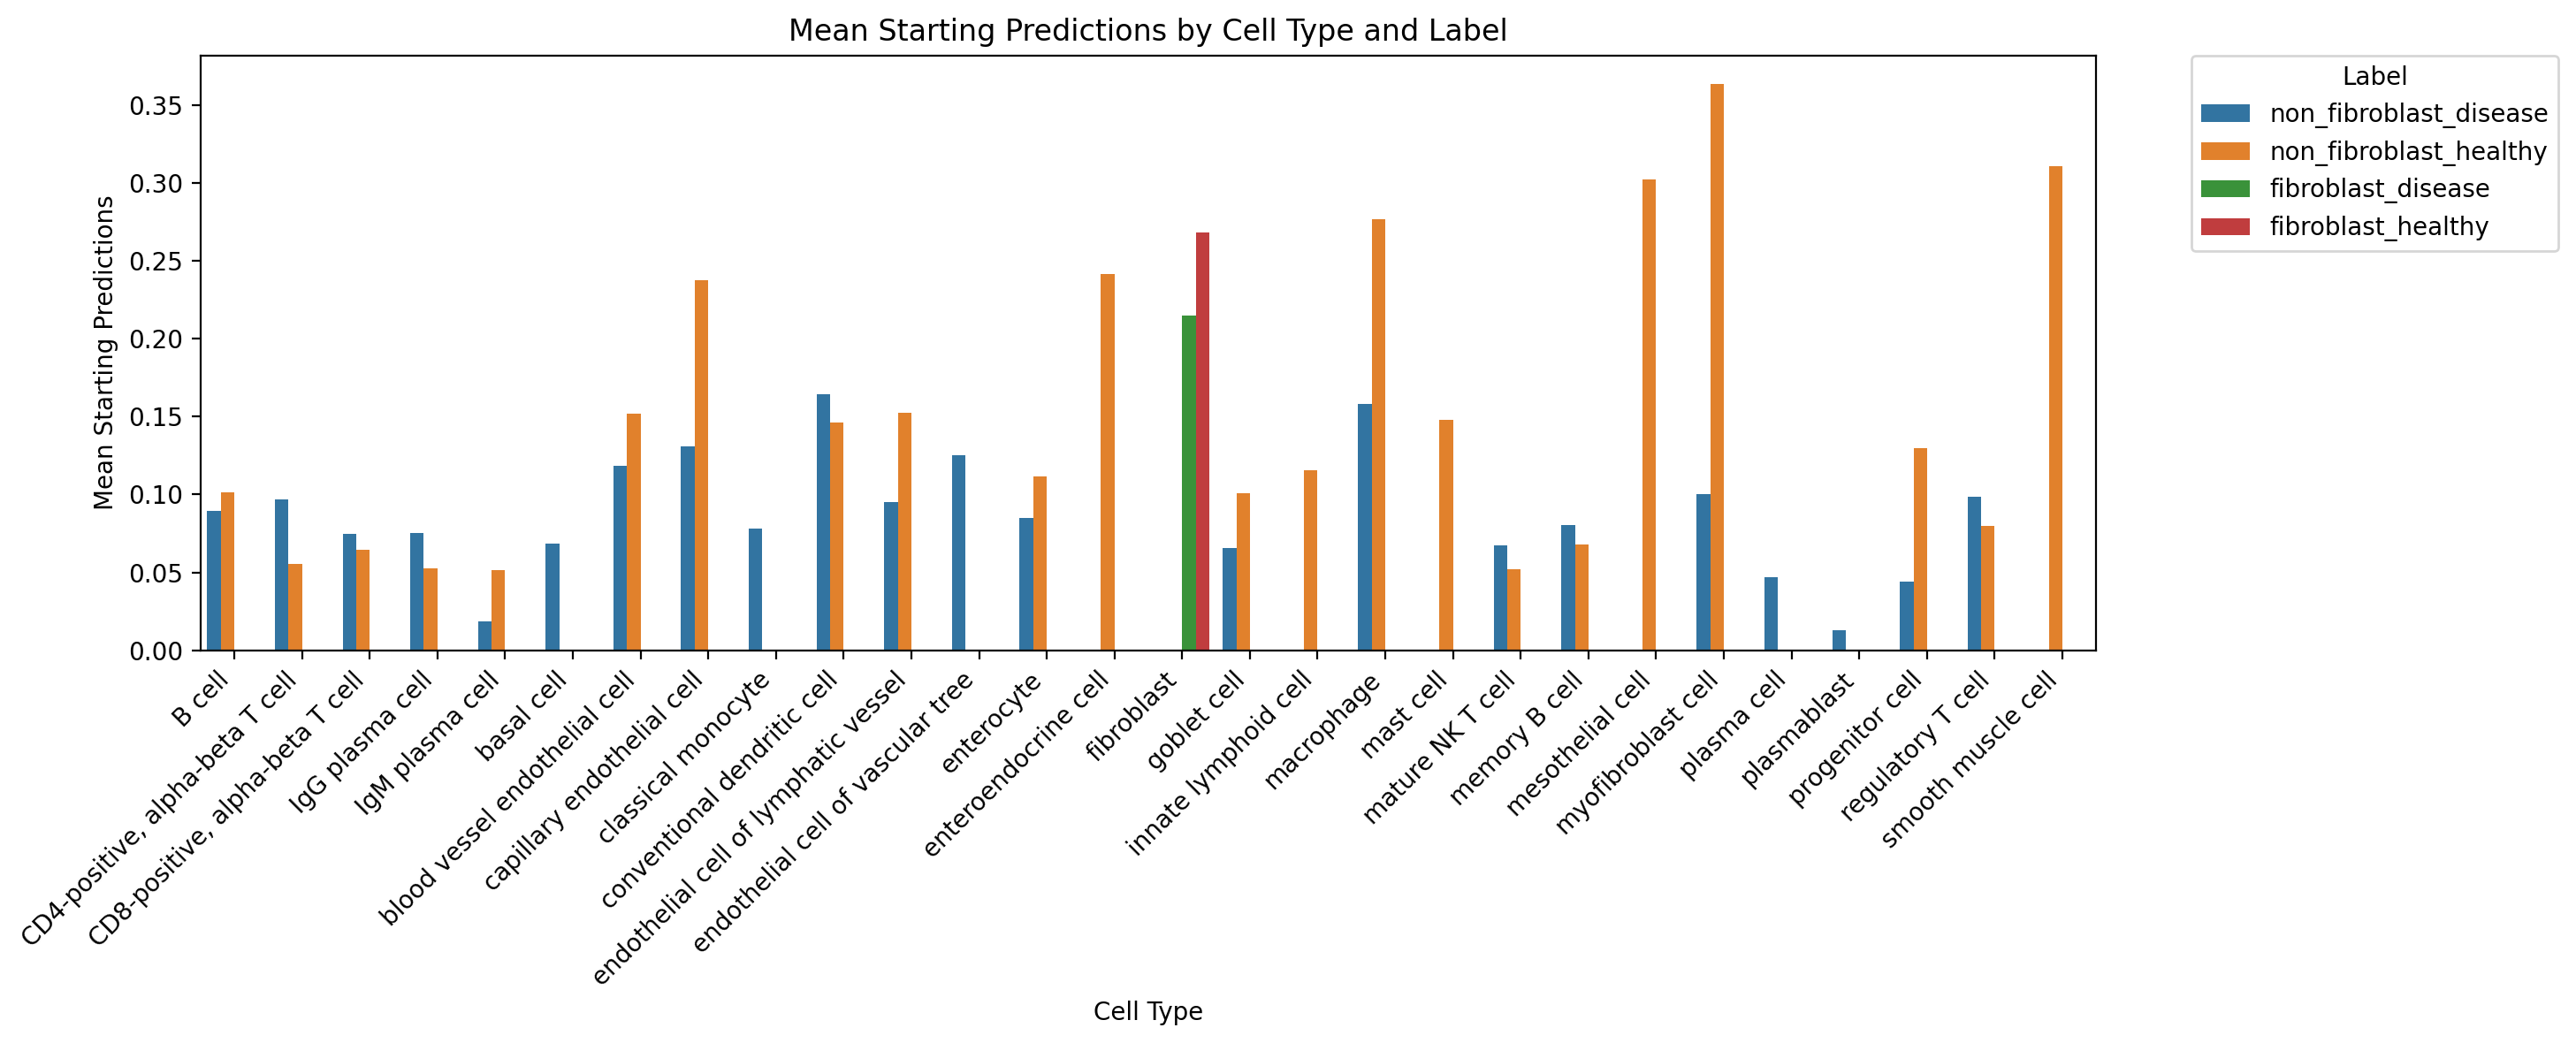

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming taskF is your DataFrame
subF = taskF[taskF['label'] != 'excluded']

# Calculate mean starting_preds for each cell_type and label combination
mean_preds = subF.groupby(['cell_type', 'label'])['starting_preds'].mean().reset_index()

# Create the plot
plt.figure(figsize=(14, 6), dpi=200)
sns.barplot(data=mean_preds, x='cell_type', y='starting_preds', hue='label')

# Customize the plot
plt.title('Mean Starting Predictions by Cell Type and Label')
plt.xlabel('Cell Type')
plt.ylabel('Mean Starting Predictions')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Show the plot
plt.show()

# Evolve

In [21]:
from grelu.sequence.mutate import mutate
import csv
rounds = 50

In [22]:
def directed_evolution(full_inserted_sequence, inserted_seq, TSS_offset, rounds, diseaseF, healthyF, output_csv, cargo=EBFP_seq):
    current_sequence = full_inserted_sequence
    
    with open(output_csv, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Round', 'Position', 'Base', 'Specificity', 'Current_Sequence'])
        
        for round_num in tqdm(range(rounds), desc="Rounds"):
            best_mutation = {
                'position': -1,
                'base': '',
                'specificity': float('-inf')
            }
            
            for position in range(TSS_offset, TSS_offset + len(inserted_seq)):
                for base in ['A', 'T', 'G', 'C']:
                    if base == current_sequence[position]:
                        continue
                    
                    new_seq = mutate(current_sequence, allele=base, pos=position)
                    current_element = new_seq[TSS_offset:TSS_offset+len(inserted_seq)]
                    
                    preds = make_pred(new_seq, current_element+cargo)
                    healthy_preds = preds[healthyF.index].mean()
                    disease_preds = preds[diseaseF.index].mean()
                    specificity = disease_preds - healthy_preds
                    
                    if specificity > best_mutation['specificity']:
                        best_mutation = {
                            'position': position,
                            'base': base,
                            'specificity': specificity
                        }
            
            current_sequence = mutate(current_sequence, allele=best_mutation['base'], pos=best_mutation['position'])
            current_element = current_sequence[TSS_offset:TSS_offset+len(inserted_seq)]
            
            csvwriter.writerow([
                round_num + 1,
                best_mutation['position'],
                best_mutation['base'],
                best_mutation['specificity'],
                current_element
            ])
            csvfile.flush()  # Ensure data is written to the file immediately
            
            print(f"Round {round_num+1}: Best specificity = {best_mutation['specificity']:.4f}, "
                  f"Position = {best_mutation['position']}, Base = {best_mutation['base']}")
    
    return current_element, best_mutation['specificity']


In [ ]:
inserted_seq = random_starting_sequence
filename = save_file + '_part1.csv'

diseaseF = cell_typeF
healthyF = non_cell_typeF
result, specificity = directed_evolution(full_inserted_sequence, inserted_seq, TSS_offset, rounds, diseaseF, healthyF, filename)

Rounds:   2%|███▏                                                                                                                                                         | 1/50 [03:12<2:37:10, 192.45s/it]

Round 1: Best specificity = 0.1527, Position = 164002, Base = C


Rounds:   4%|██████▎                                                                                                                                                      | 2/50 [06:28<2:35:31, 194.41s/it]

Round 2: Best specificity = 0.1848, Position = 163843, Base = A


Rounds:   6%|█████████▍                                                                                                                                                   | 3/50 [09:52<2:35:56, 199.08s/it]

Round 3: Best specificity = 0.2151, Position = 163952, Base = A


Rounds:   8%|████████████▌                                                                                                                                                | 4/50 [13:10<2:32:14, 198.58s/it]

Round 4: Best specificity = 0.2422, Position = 163988, Base = G


Rounds:  10%|███████████████▋                                                                                                                                             | 5/50 [16:20<2:26:30, 195.35s/it]

Round 5: Best specificity = 0.2784, Position = 163926, Base = A


Rounds:  12%|██████████████████▊                                                                                                                                          | 6/50 [19:31<2:22:18, 194.06s/it]

Round 6: Best specificity = 0.3215, Position = 164026, Base = G


Rounds:  14%|█████████████████████▉                                                                                                                                       | 7/50 [22:36<2:16:55, 191.06s/it]

Round 7: Best specificity = 0.3691, Position = 163979, Base = T


Rounds:  16%|█████████████████████████                                                                                                                                    | 8/50 [25:47<2:13:34, 190.82s/it]

Round 8: Best specificity = 0.4265, Position = 163967, Base = T


Rounds:  18%|████████████████████████████▎                                                                                                                                | 9/50 [28:51<2:09:05, 188.91s/it]

Round 9: Best specificity = 0.4778, Position = 163865, Base = T


Rounds:  20%|███████████████████████████████▏                                                                                                                            | 10/50 [32:01<2:06:04, 189.12s/it]

Round 10: Best specificity = 0.5393, Position = 163907, Base = T


Rounds:  22%|██████████████████████████████████▎                                                                                                                         | 11/50 [35:16<2:04:13, 191.11s/it]

Round 11: Best specificity = 0.6198, Position = 163904, Base = A


Rounds:  24%|█████████████████████████████████████▍                                                                                                                      | 12/50 [38:24<2:00:25, 190.14s/it]

Round 12: Best specificity = 0.6982, Position = 163893, Base = A


Rounds:  26%|████████████████████████████████████████▌                                                                                                                   | 13/50 [41:33<1:57:01, 189.77s/it]

Round 13: Best specificity = 0.7579, Position = 163853, Base = A


Rounds:  28%|███████████████████████████████████████████▋                                                                                                                | 14/50 [44:50<1:55:05, 191.82s/it]

Round 14: Best specificity = 0.8150, Position = 163959, Base = C


Rounds:  30%|██████████████████████████████████████████████▊                                                                                                             | 15/50 [48:23<1:55:34, 198.12s/it]

Round 15: Best specificity = 0.8683, Position = 163913, Base = A


Rounds:  32%|█████████████████████████████████████████████████▉                                                                                                          | 16/50 [51:57<1:55:04, 203.08s/it]

Round 16: Best specificity = 0.9233, Position = 163859, Base = T


Rounds:  34%|█████████████████████████████████████████████████████                                                                                                       | 17/50 [55:55<1:57:24, 213.47s/it]

Round 17: Best specificity = 0.9921, Position = 163850, Base = T


Rounds:  36%|████████████████████████████████████████████████████████▏                                                                                                   | 18/50 [59:56<1:58:14, 221.71s/it]

Round 18: Best specificity = 1.0357, Position = 163878, Base = T


Rounds:  38%|██████████████████████████████████████████████████████████▌                                                                                               | 19/50 [1:03:58<1:57:48, 228.01s/it]

Round 19: Best specificity = 1.0825, Position = 163845, Base = A


Rounds:  40%|█████████████████████████████████████████████████████████████▌                                                                                            | 20/50 [1:08:00<1:55:59, 231.97s/it]

Round 20: Best specificity = 1.1598, Position = 163841, Base = G


Rounds:  42%|████████████████████████████████████████████████████████████████▋                                                                                         | 21/50 [1:12:02<1:53:37, 235.07s/it]

Round 21: Best specificity = 1.2881, Position = 163846, Base = C


Rounds:  44%|███████████████████████████████████████████████████████████████████▊                                                                                      | 22/50 [1:16:05<1:50:48, 237.43s/it]

Round 22: Best specificity = 1.4217, Position = 163848, Base = T


In [28]:
mutationF_1

,Round,Position,Base,Specificity,Current_Sequence
0,1,164002,C,0.152660,GTAGGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
1,2,163843,A,0.184817,GTAAGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
2,3,163952,A,0.215096,GTAAGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
3,4,163988,G,0.242215,GTAAGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
4,5,163926,A,0.278426,GTAAGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
5,6,164026,G,0.321547,GTAAGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
6,7,163979,T,0.369084,GTAAGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
7,8,163967,T,0.426531,GTAAGTAAGCGGGGTATTTGCACTTCCCTTAATCCATAAGGGCTTT...
8,9,163865,T,0.477807,GTAAGTAAGCGGGGTATTTGCACTTTCCTTAATCCATAAGGGCTTT...
9,10,163907,T,0.539317,GTAAGTAAGCGGGGTATTTGCACTTTCCTTAATCCATAAGGGCTTT...


In [ ]:
mutationF_1 = pd.read_csv(filename)
evolved_seq = mutationF_1.iloc[49].Current_Sequence
evolved_seq

# Evolve w/ disease - P2

In [ ]:
full_inserted_sequence_evolved = place_sequence(full_sequence, evolved_seq + EBFP_seq, TSS_offset)


In [ ]:
filename = save_file + '_part2.csv'

diseaseF = cell_type_disease
healthyF = cell_type_healthy
result, specificity = directed_evolution(full_inserted_sequence_evolved, evolved_seq, 
                                         TSS_offset, rounds, diseaseF, healthyF, filename)
